In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, StandardScaler
from pylab import rcParams
import scipy.cluster.hierarchy as sch

### Define two functions for cluster analysis visualisation

In [5]:
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates


def pd_centers(featuresUsed, centers):

    colNames = list(featuresUsed)
    colNames.append('prediction')

    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]

    # Convert to pandas for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P

def parallel_plot(data):

    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([1,5])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')
    plt.xticks(rotation=75)

## **1. Prepare the dataset**

In [6]:
responses = pd.read_csv("responses.csv")

responses.at[676,'Height'] += 100 # repair a value

### Divide dataset onto severall parts

In [7]:
music = responses.loc[:,'Dance':'Opera']
movies = responses.loc[:,'Horror':'Action']
hobbies = responses.loc[:,'History':'Pets']
phobias = responses.loc[:,'Flying':'Fear of public speaking']
personality = responses.loc[:,'Daily events':'Spending on healthy eating'].select_dtypes(include=['int','float'])

### **Define a new feature called 'braveness'**
Negation of 'breaveness' is a scaled sum of individual's ratings of all phobias. <i>Potentially could correlate with some features.</i>

*Note: highter value = more brave.*

Text(0, 0.5, 'Density')

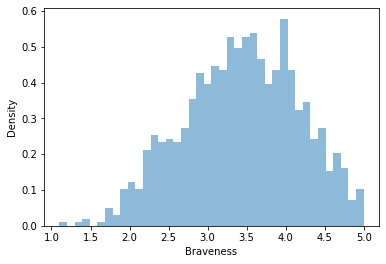

In [8]:
braveness = (50-phobias.sum(axis=1)) / 10 + 1
braveness.plot.hist(bins=40, alpha=0.5, density = True)

responses_ = responses.copy()
responses_.insert(0, "Braveness", braveness.to_list(), True)

plt.xlabel('Braveness')
plt.ylabel('Density')

### **Filter responses leaving only numerical values**

In [9]:
responses_int = responses_.select_dtypes(include=['int','float'])
print(responses_.shape, responses_int.shape)

(1010, 151) (1010, 140)


## **2. Search for correlations**

### **Divide data set onto male/female slice**

In [10]:
responses_int_filtered = responses_int[responses['Gender'] == 'female']
responses_male = responses_int[responses['Gender'] == 'male']
responses_female = responses_int[responses['Gender'] == 'female']

### Principal Component analysis (PCA)

In [30]:
# Select what slice of responders table you want to analyse
# Choose TYPE from [music, hobbies, movies, phobias, personality] (name-format, not string-format)

def PCA(TYPE):
    
    df = TYPE.dropna()
    df_np = np.array(df)

    # Calculate covarriance matrix for all features (columns) in TYPE

    Sigma = np.cov(df_np, rowvar=0, bias=1)

    # Calculate eigenvectors of covarriance matrix

    eigenvalues, eigenvectors = np.linalg.eigh(Sigma)
    
    
    plt.plot([0]+[sum(eigenvalues[-i:]) / sum(eigenvalues) for i in range(1, TYPE.shape[1]+1)])
    plt.xlabel('number of considered components')
    plt.ylabel('accumulated fraction of total variance')
    
    
    return lambda i: sum(eigenvalues[-i:]) / sum(eigenvalues)

0.8078500266213285


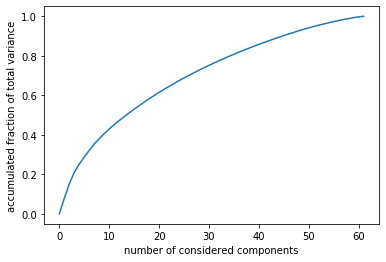

In [32]:
print(PCA(personality)(35)) # cumulative variance from 35 biggest components

For `TYPE = personality` 5 most impactful personality features occupy only 29% of total variance, what means that features are not very correlated (rather independent). To cover up 80% of total variance it's necessarily to take 35 most impactful features out of total 61.

### 2.1. Plot correlations of all features (all types) with a chosen `FEATURE`
Consider `men` and `women` datasets together.

Features correlated with 'Number of friends':


,Feature's name,Coefficient
61,Fun with friends,0.369
98,Loneliness,-0.287
105,Number of friends,1.000
110,Socializing,0.323
120,Happiness in life,0.299
121,Energy levels,0.367
123,Personality,0.275
126,Interests or hobbies,0.372


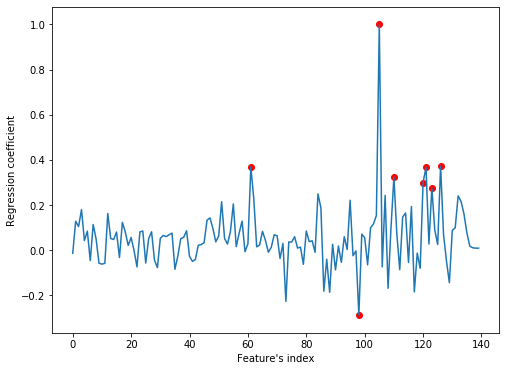

In [13]:
#FEATURE = 'Loneliness'
FEATURE = 'Number of friends'


rcParams['figure.figsize'] = 8,6

cols = responses_int_filtered.columns.to_list()

correlations = [responses_int_filtered[FEATURE].corr(responses_int_filtered[f]) for f in cols]


df = pd.DataFrame(correlations, columns = ['Correlations'])
df = df[abs(df['Correlations']) > 0.25]

corr_features = [cols[f] for f in df.index]

corr = responses_int_filtered[corr_features].corr().loc[:,FEATURE]#.drop([FEATURE])
print("Features correlated with '{}':".format(FEATURE))
corr_ = {'Feature\'s name':corr.index, 'Coefficient':round(corr,3).to_list()}
corr_ = pd.DataFrame(corr_, index = df.index)
display(corr_)


plt.plot(correlations)
plt.xlabel('Feature\'s index')
plt.ylabel('Regression coefficient')
plt.scatter(df.index, np.array(corr), c='r')
plt.show()

Red dots correspond to features correlated with `FEATURE`.

### 2.2. Search for interesting correlations
Consider `men` and `women` independently.

Find what features have most correlations with any of 'personality' features.
Find features that lead to correlations with similar Pearson's value for *both men and women treated separently*. This approach is crucial, because i.e. if `men` are more likely to be interested in `cars` than `women`, and at the same time `men` are statisticaly `heigher` that `women`, then without considering gender independence we would get a correlation between `cars` and `height`, which is a nonsense.

In [37]:
# Index _1 stands for men, index_2 stands for women

for FEATURE in personality.columns:

    cols = responses_int_filtered.columns.to_list()

    correlations_1 = [responses_male[FEATURE].corr(responses_male[f]) for f in cols ]
    correlations_2 = [responses_female[FEATURE].corr(responses_female[f]) for f in cols ]


    df_1 = pd.DataFrame(correlations_1, columns = ['Correlations'])
    df_1 = df_1[ abs(df_1['Correlations']) > 0.25]
    df_2 = pd.DataFrame(correlations_2, columns = ['Correlations'])
    df_2 = df_2[ abs(df_2['Correlations']) > 0.25]


    corr_features_1 = [cols[f] for f in df_1.index]
    corr_features_2 = [cols[f] for f in df_2.index]


    corr_1 = responses_male[corr_features_1].corr().loc[:,FEATURE].drop([FEATURE])
    corr_2 = responses_female[corr_features_2].corr().loc[:,FEATURE].drop([FEATURE])

    # Find set of features  lead to correlations in both genders
    set_ = set(corr_1.index) & set(corr_2.index)
    
    
    # If at least 5 distinct correlation are found
    if len(corr_1) > 0 and len(set_) > 5:
        
        corr_ = {'Correlated feature\'s name':list(set_)
                 , 'Coefficient for Men':round(corr_1,3).loc[set_].tolist()
                 , 'Coefficient for Women':round(corr_2,3).loc[set_].tolist()}
        
        corr_ = pd.DataFrame(corr_)
        corr_ = corr_.style.set_caption("Feature\'s name: {}".format(FEATURE)).hide_index()
        print("Feature\'s name: {}:".format(FEATURE))
        display(corr_)

Feature's name: Number of friends:


Correlated feature's name,Coefficient for Men,Coefficient for Women
Interests or hobbies,0.382,0.372
Socializing,0.35,0.323
Energy levels,0.427,0.367
Loneliness,-0.345,-0.287
Happiness in life,0.336,0.299
Fun with friends,0.345,0.369
Personality,0.273,0.275


Feature's name: Energy levels:


Correlated feature's name,Coefficient for Men,Coefficient for Women
Interests or hobbies,0.493,0.392
Socializing,0.365,0.303
New environment,0.325,0.364
Loneliness,-0.336,-0.355
Happiness in life,0.448,0.433
Number of friends,0.427,0.367
Personality,0.33,0.325
Active sport,0.319,0.322
Fear of public speaking,-0.281,-0.256


Feature's name: Spending on looks:


Correlated feature's name,Coefficient for Men,Coefficient for Women
Appearence and gestures,0.352,0.406
Spending on gadgets,0.354,0.41
Celebrities,0.267,0.278
Knowing the right people,0.327,0.287
Shopping centres,0.478,0.483
Entertainment spending,0.385,0.47
Shopping,0.455,0.544
Branded clothing,0.482,0.422


## 3. Clustering

### 3.1. Hierarchical clustering for a chosen `FEATURE`

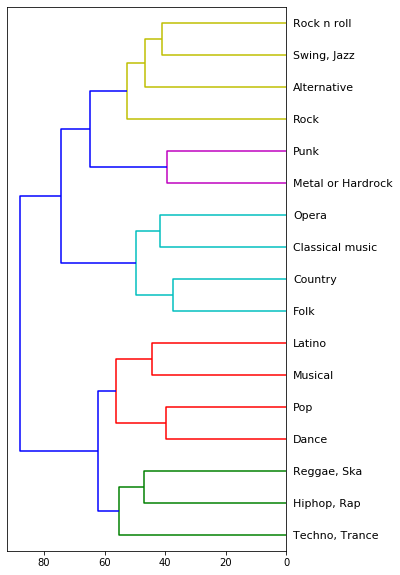

In [15]:
FEATURE = music  # [music, hobbies, phobias, personality]

df_select = FEATURE.copy(deep=True).dropna()
x = df_select.to_numpy().T
#
# Adjust figure size to accommodate the full tree
#
rcParams['figure.figsize'] = 5, 10
#
# Do hierarchical clustering using Ward's method
#
z = sch.linkage(x, method='ward')
#
# Display dendrogram
#
names = df_select.columns.tolist()
info = sch.dendrogram(z, orientation='left', labels=names, leaf_font_size=11)

**Comment 1:** there seem to be 3 kinds of correlated `phobias`:
- animals (Rats, Snakes, Dangerous dogs, Spiders)
- nature (Darkness, Storm, Flying)
- social (Fear of public speaking, Heights, Ageing)

**Comment 2:** `music` clusters in 5 similar types:
- **old music**: rock n roll, jazz, alternative
- **metal-like music**: rock**, punk, metal
- **instrumental music**": opera, classical, country, folk
- **popular music**: latino, musical, pop, dance
- **rap-like music**: reggae, hiphip, techno

** although rock was assigned to 'yellow label', it's not too far from 'magenta label', which seems more logical

### 3.2. K-means clustering for a chosen `FEATURE`

In [16]:
FEATURE = phobias  # [music, hobbies, phobias, personality]

df_select = FEATURE.copy(deep=True).dropna()

# Perform scaling on the dataframe containing the features

scaler_x = StandardScaler()
data = scaler_x.fit_transform(df_select)

# Generate answers for various numbers of clusters

sse = {}
for k in range(1,11):
    model = KMeans(init='k-means++', n_clusters=k, n_init=20).fit(data)
    sse[k] = model.inertia_

### Elbow method
Analysing `loss function` vs `numbers of clusters` plot to choose adequate number of clusters.

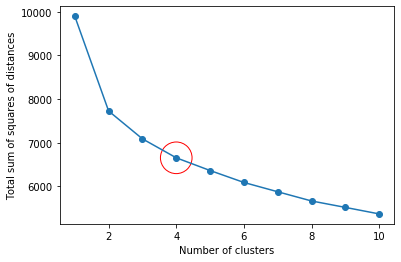

In [17]:
rcParams['figure.figsize'] = 6,4

plt.plot(list(sse.keys()), list(sse.values()), 'o', linestyle = '-')
plt.scatter( [4],[sse[4]], s = 1000, c = 'none', edgecolor = 'red')
plt.xlabel('Number of clusters')
plt.ylabel('Total sum of squares of distances')

# Choose number of clusters

noOfClusters = 4

model = KMeans(init='k-means++', n_clusters=noOfClusters, n_init=20).fit(data)

In [18]:
print(90*'_')
print("\nCount of people in each cluster")
print(90*'_')

pd.value_counts(model.labels_, sort=False)

__________________________________________________________________________________________

Count of people in each cluster
__________________________________________________________________________________________


0    250
1    256
2    286
3    198
dtype: int64

### Plot centers of individual clusters

In [19]:
P = pd_centers(featuresUsed=phobias.columns.to_list(), centers=scaler_x.inverse_transform(model.cluster_centers_))
P

,Flying,Storm,Darkness,Heights,Spiders,Snakes,Rats,Ageing,Dangerous dogs,Fear of public speaking,prediction
0,1.768000,1.732000,1.988000,2.292000,3.516000,4.084000,3.364000,2.884000,3.668000,2.732000,0
1,2.269531,1.675781,2.386719,3.105469,2.648438,2.359375,1.695312,2.710938,2.675781,3.308594,1
2,1.430070,1.353147,1.374126,1.744755,1.744755,1.881119,1.367133,1.727273,2.146853,2.094406,2
3,3.010101,3.530303,3.646465,3.606061,3.752525,4.227273,3.621212,3.232323,4.010101,3.282828,3


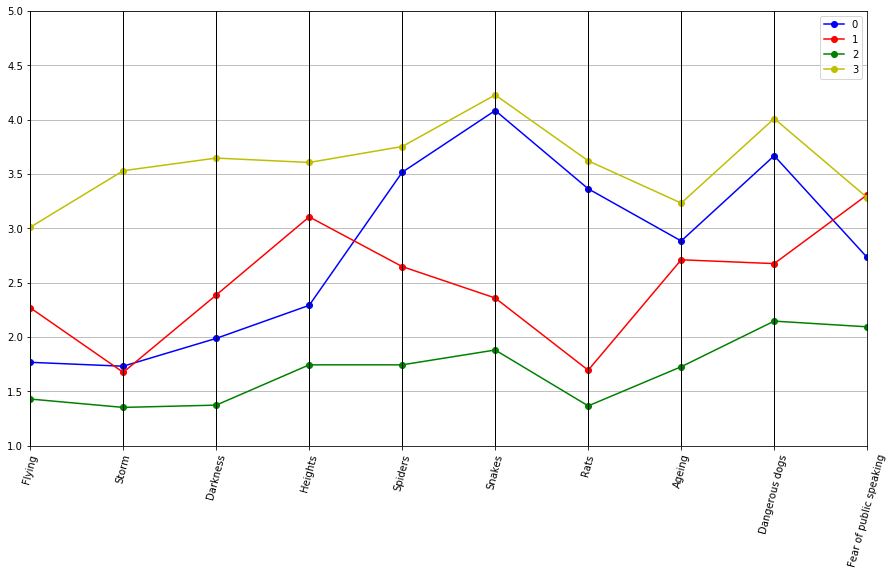

In [20]:
parallel_plot(P)

**Interpretation** (valid for 4 clusters). People seem to divide in 4 different types, according to `phobias` (following bullets are ordered from the bottom at the label `Flying`):

- people scared of nothing.
- people scared of various animals.
- people scared of everything except of animals.
- people scared of everything.

### Find outliners
People who likely cheated by answering randomly.

Number of survey responser and its distance from nearest cluster:

458 	 4.6395605695635505
516 	 4.6902843215182966
614 	 4.707513102369494
932 	 4.300967946578844
989 	 4.438399156165899

All non-numeric informations about surveyors detected as outliers:


,Education,Internet usage,Village - town,Lying,Smoking,Gender,House - block of flats,Left - right handed,Only child,Punctuality,Alcohol
458,secondary school,few hours a day,village,only to avoid hurting someone,tried smoking,female,house/bungalow,right handed,no,i am often running late,social drinker
516,secondary school,few hours a day,city,sometimes,tried smoking,male,block of flats,right handed,no,i am always on time,never
614,secondary school,few hours a day,village,sometimes,current smoker,female,house/bungalow,right handed,no,i am often early,social drinker
932,secondary school,few hours a day,city,sometimes,tried smoking,female,block of flats,right handed,no,i am often early,social drinker
989,masters degree,most of the day,village,sometimes,former smoker,female,house/bungalow,right handed,no,i am often early,drink a lot


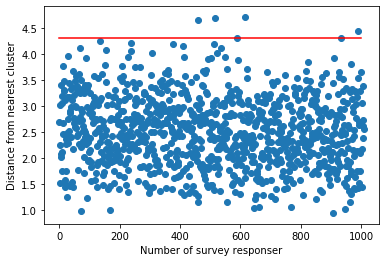

In [21]:
centers = model.cluster_centers_

# Maximum allowed distance from nearest cluster to not be considered as an outliner
    
RANGE = 4.3

# Plot distance from nearest cluster for all points for which cluster analysis was conducted
#
x = df_select.index.tolist()
y = [min([np.linalg.norm(a-b) for a in centers]) for b in data[:] ]
plt.scatter(x,y)
plt.plot([0,1000], [RANGE,RANGE], 'red') # above this line are outliners
plt.xlabel("Number of survey responser")
plt.ylabel("Distance from nearest cluster")


# Find which points are far away from any cluster. Print their indexies and measured distances
#
print( "Number of survey responser and its distance from nearest cluster:\n")
for i in range( 0, len(y)):
    if y[i] > RANGE:
        print (x[i],'\t',y[i])


# Select indexies of these points
#
outliners = [ i > RANGE for i in y]
outliners = df_select[ outliners]


# Find all informations about people who seem to be outliners
#
filter_ = np.full( responses.shape[0], False)
for i in range( 0, outliners.shape[0]):
    filter_[ outliners.index[i]] = True
    
    
print( "\nAll non-numeric informations about surveyors detected as outliers:")
df_ = responses[ filter_]
   
# Select columns including only strings

df_cols = set(df_.columns) - set(df_.select_dtypes(include=['int','float']).columns)
df_[df_cols]

**Comment:** Seems like almost all of the outliners are woman.

## 4. Analysis of `non-numerical` features
This corresponds to features like `gender` or `left/right handling`.
### 4.1. BMI (body mass index) distribution analysis within genders

In [22]:
bmi = responses['Weight'] / (responses['Height'] / 100)**2

responses_ = responses.copy()
responses_.insert(0, "Braveness", braveness.to_list(), True)
responses_.insert(0, "BMI", bmi.to_list(), True)


left_ = responses_[responses_['Left - right handed'] == 'left handed']
right_ = responses_[responses_['Left - right handed'] == 'right handed']

male_ = responses_[responses_['Gender'] == 'male']
female_ = responses_[responses_['Gender'] == 'female']

Text(0, 0.5, 'Density')

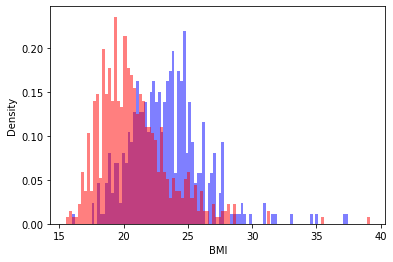

In [23]:
male_['BMI'].plot.hist(bins=100, alpha=0.5, color = 'blue', density = True)
female_['BMI'].plot.hist(bins=100, alpha=0.5, color = 'red', density = True)

rcParams['figure.figsize'] = 6,4
plt.xlabel('BMI')
plt.ylabel('Density')

**Interpretation:** both genders have gaussian-like distribution of BMI values, however their mean values differ:
- women's average BMI is around 20
- men's average BMI is around 24

### 4.2. Comparision of woman's and man's faith (religious aspect)

Men's fraction distribution:


5.0    0.255474
1.0    0.236010
3.0    0.214112
4.0    0.160584
2.0    0.133820
Name: God, dtype: float64

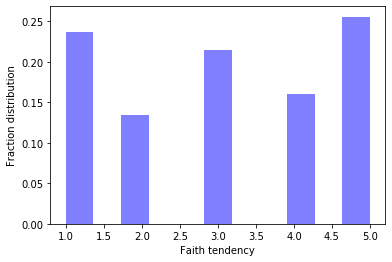

In [24]:
n = sum(male_['God'] == male_['God'])  # Disclude nan values in this feature's column

male_['God'].plot.hist(bins=11, alpha=0.5, color = 'blue', weights = [1./n for i in range(0,n)])
plt.xlabel('Faith tendency')
plt.ylabel('Fraction distribution')

print("Men's fraction distribution:")
male_['God'].value_counts(normalize=True)

Women's fraction distribution:


5.0    0.358714
3.0    0.211506
4.0    0.165821
1.0    0.152284
2.0    0.111675
Name: God, dtype: float64

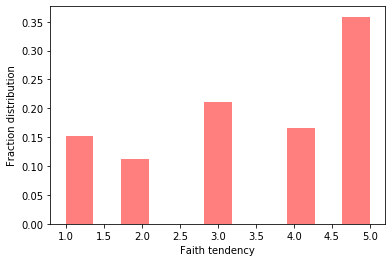

In [25]:
n = sum(female_['God'] == female_['God'])  # Disclude nan values in this column

female_['God'].plot.hist(bins=11, alpha=0.5, color = 'red', weights = [1./n for i in range(0,n)])
plt.xlabel('Faith tendency')
plt.ylabel('Fraction distribution')

print("Women's fraction distribution:")
female_['God'].value_counts(normalize=True)

**Interpretation:** woman are more likely to be religious.
- 36% of woman and 25% of men are strongly religious (5.0 points in survey).
- 15% of woman and 24% of men are atheist-like (1.0 point in survey).